# General extended source extracion 
Based on: [https://photutils.readthedocs.io/en/stable/user_guide/segmentation.html](https://photutils.readthedocs.io/en/stable/user_guide/segmentation.html)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from photutils.background import Background2D, MedianBackground
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel, detect_sources, SourceCatalog

from astropy.stats import sigma_clipped_stats #to characterize the background
from astropy.visualization import SqrtStretch #for visualization of the fits files
from astropy.visualization.mpl_normalize import ImageNormalize #for visualization of the fits files
from astropy.io import fits

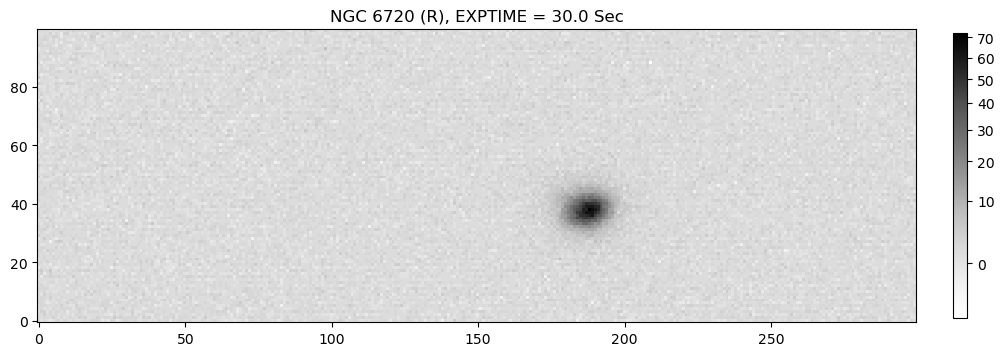

In [3]:
master_bias_average = 153.79 #average of master (average) bias frame

hdu = fits.open("water_tribe/HD 175544/Halpha/118.fit")
hdr = hdu[0].header #to get exposure time
data = hdu[0].data[250:350, 650:950] #full image is 512X2048
data = data - master_bias_average
plt.figure(figsize=(12, 12))
norm = ImageNormalize(stretch=SqrtStretch()) #for imshow display
plt.imshow(data, cmap='Greys', origin='lower', interpolation='nearest', norm=norm) #vmax = 5 required to see the stars.
plt.title("NGC 6720 (R), EXPTIME = " + str(hdr['EXPTIME']) + " Sec")
im_ratio = data.shape[0]/data.shape[1] 
plt.colorbar(fraction=0.046*im_ratio, pad=0.04) #to scale colorbar to size of frame
hdu.close()

<photutils.segmentation.core.SegmentationImage>
shape: (100, 300)
nlabels: 1
labels: [1]


Text(0.5, 1.0, 'Segmentation Image')

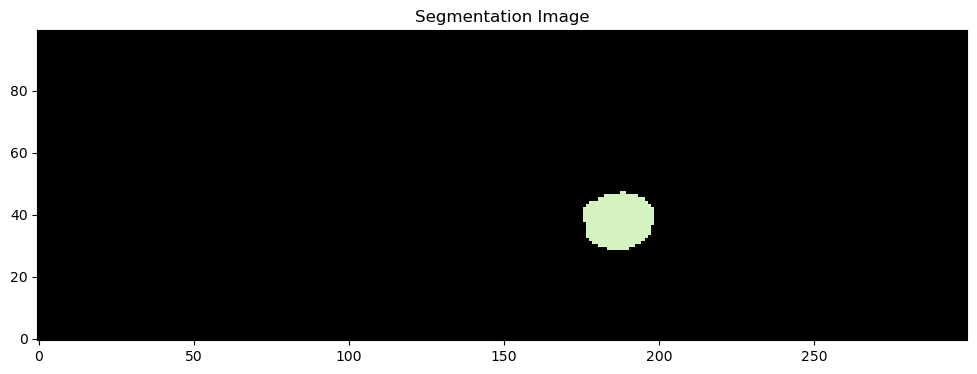

In [4]:

bkg_estimator = MedianBackground() # background estimation
bkg = Background2D(data, (50, 50), filter_size=(3, 3),
                bkg_estimator=bkg_estimator)
data -= bkg.background  # subtract the background

threshold = 5.0 * bkg.background_rms

#convolve with kernel to increase S/N 
kernel = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.0
convolved_data = convolve(data, kernel)

segment_map = detect_sources(convolved_data, threshold, npixels=10) #10 connected pixels greater than threshold
print(segment_map)

plt.figure(figsize=(12, 12))
plt.imshow(segment_map, origin='lower', cmap=segment_map.cmap,
           interpolation='nearest')
plt.title('Segmentation Image')

In [5]:
cat = SourceCatalog(data, segment_map, convolved_data=convolved_data) #photometry
tbl = cat.to_table()
tbl['xcentroid'].info.format = '.2f'  # optional format
tbl['ycentroid'].info.format = '.2f'
tbl['kron_flux'].info.format = '.2f'
print(tbl)

label xcentroid ycentroid ... segment_fluxerr kron_flux kron_fluxerr
                          ...                                       
----- --------- --------- ... --------------- --------- ------------
    1    187.37     37.76 ...             nan   7371.98          nan


In [ ]:
# to filter out stars can create a mask with the point sources found from DAOFind